In [1]:
# Import libraries
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from random import randint
import numpy as np

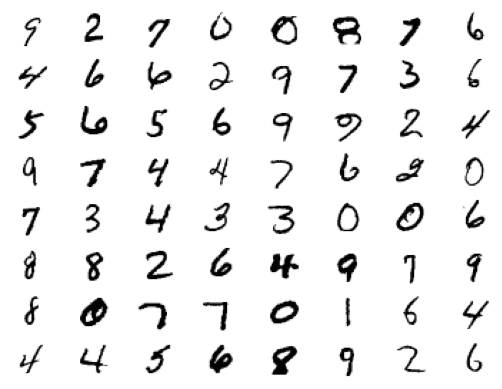

In [2]:
# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) /255
x_test = x_test.reshape(x_test.shape[0], image_size)/255

# Convert class vectors to binary class matrices
num_classes = 10
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

In [3]:
# Define cost functions

# Condition metric
def H(X, y, theta):
    y = y.reshape(y.shape[0], 1) # change to 2d array
    return (1 - y * (X@theta))

# SVM loss function
def svm_loss_re(X, y, theta, lamda):
    h = H(X, y, theta)
    penalty = lamda*(theta.T @ theta)
    loss = np.mean([max(0, i) for i in h])
    return np.ndarray.item(penalty) + (loss) 

def svm_grad_re(X, y, theta, lamda):
    h = H(X, y, theta)
    grad = np.zeros_like(theta)
    for i in range(h.shape[0]):
        if h[i] >= 1:
            grad += 0
        else:
            grad += -y[i]*X[i,:].reshape(-1,1)
    grad /= h.shape[0]
    grad += 2*lamda*theta
    return grad

In [4]:
#Split dataset to num_worker workers
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)

    return data_X_list, data_y_list

# Function to train master-worker
def train(X_data, y, num_worker, num_iter, var, pLevel, lamda, alpha, lr_fade=1):

    # lamda: penalty
    # alpha: learning rate
    # var: noise variance
    # pLevel: noise adding probability
    # num_iter: number of iterations

    # Split into 10 subdatasets for 10 workers
    data_X_list, data_y_list = split_workers(X_data, y, num_worker)
    
    # train
    weight = np.random.rand(X_data.shape[1], 1)
    total_loss_list=[]
    for i_iter in range(num_iter):
        gradient_list=[]
        for j_worker in range(num_worker):
            # call data_j from worker j
            X_data_worker = data_X_list[j_worker]
            y_data_worker = data_y_list[j_worker]
            
            # get grad from worker j
            gradient = svm_grad_re(X_data_worker, y_data_worker, weight, lamda)
            
            # add noise
            if np.random.rand() < pLevel:
                noise = np.random.normal(0, var, (X_data.shape[1], 1))
                gradient += noise
                
            gradient_list.append(gradient)
        grad_ave = 1./num_worker*sum(gradient_list)
        alpha *= lr_fade
        weight -= alpha * grad_ave
        total_loss_list.append(svm_loss_re(X_data, y, weight, lamda))
    
    return total_loss_list



In [17]:
num_worker = 10
num_iter = 100
lamda = .0001  
#lam=1e-4
alpha = .1
#alpha=.1
lr_fade = 1
#lr_fade=1



def tuningNoise(var, pLevel):
    total_loss_list = []
    for p in pLevel:
        total_loss = train(x_train, y_train, num_worker, num_iter, var, p, lamda, alpha, lr_fade)
        total_loss_list.append(total_loss)
        print(p)
    return total_loss_list

In [8]:
Loss_var_p

[[[171255.55771801106,
   124576.89773736215,
   94214.82985654465,
   73704.43606544947,
   59381.903026184096,
   49085.0758530874,
   41490.79378921129,
   35762.47353972593,
   31355.348522944827,
   27905.098655496022,
   25162.148072977332,
   22951.687701055867,
   21148.83615257022,
   19662.721404123884,
   18426.102001669315,
   17388.454605098996,
   16511.271082558473,
   15764.823494560647,
   15125.88055485408,
   14576.08513137652,
   14100.783252148149,
   13688.161939867809,
   13328.618639469609,
   13014.279816124968,
   12738.642089604979,
   12496.295424760387,
   12282.709859175064,
   12094.068280429023,
   11927.137845327874,
   11779.16551984087,
   11647.796441679284,
   11531.005538583084,
   11427.046750529924,
   11334.406665728427,
   11251.77009565862,
   11177.9911686307,
   11112.06653425593,
   11053.117466197224,
   11000.37161621093,
   10953.148585342977,
   10910.847575237969,
   10872.937733106766,
   10838.948899485124,
   10808.46371680366,
   1

In [18]:
Loss_var_p = []
pLevel = [0.1,  0.9]
#pLevel = [0.1, 0.3, 0.5, 0.7, 0.9]

varList = [0.001,  10]
#varList = [0.001, 0.01, 0.1, 1, 10]


for var in varList:
    Loss_var_p.append(tuningNoise(var, pLevel))
    print(var)



C:\Users\yesto\AppData\Local\Temp\ipykernel_988\1554876908.py:22: RuntimeWarning: overflow encountered in scalar negative
  grad += -y[i]*X[i,:].reshape(-1,1)


0.1
0.9
0.001
0.1
0.9
10


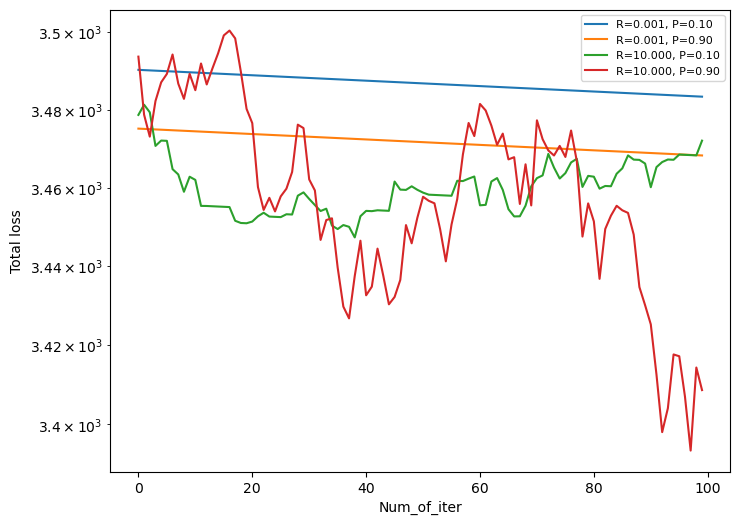

In [16]:

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

x_axis = np.arange(0, num_iter)
for i in range(len(varList)):
    for j in range(len(pLevel)):
        plt.semilogy(x_axis, Loss_var_p[i][j], label='R=%.3f, P=%.2f' % (varList[i], pLevel[j]))
    
plt.xlabel('Num_of_iter')
plt.ylabel('Total loss')
plt.legend(loc='upper right', prop={'size': 8})
plt.show()
